# Gaussian Processes the Functional Way

In [175]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

These next few functions provide the basic functionality we'll need to work with GPs:  computing the parameters of a joint finite-dimensional distribution, sampling from a multivariate Gaussian, and computing the posterior mean and covariance functions after observing some data

In [176]:
# Given mean and covariance *functions* m(*) and k(*,*) for a Gaussian process on a space S, and a vector of points X in S,
# this function computes and returns the pair (M_X, K_XX) containing the mean *vector* M_X and covariance *matrix* K_XX for 
# the joint *finite-dimensional* Gaussian distribution of function values F_X over those points
def compute_finite_dimensional_joint_distribution(m, k, X):
    # Construct the mean vector M_X, in which M_X[i] = mu(x_i)
    M_X = np.array([m(xi) for xi in X])
    
    # Construct the covariance matrix K_XX, in which K_XX[i,j] = k(xi, xj)
    K_XX = np.zeros( (len(X), len(X)))
    for i, xi in enumerate(X):
        for j, xj in enumerate(X):
            K_XX[i,j] = k(xi, xj)
    
    return (M_X, K_XX)

In [177]:
# Draw a sample from the Gaussian process GP(m, k) over the points in the vector X
def sample_Gaussian_process(m, k, X):
    
    # Get the parameters for the finite-dimensional distribution over the points X
    FD_params = compute_finite_dimensional_joint_distribution(m, k, X)
    
    # Draw a sample from this finite-dimensional distribution
    return np.random.multivariate_normal(FD_params[0], FD_params[1])

In [178]:
# Given the mean and covariance functions mu and k for a (prior) Gaussian process, and vectors of observed inputs and outputs X and F,
# this function computes and returns the mean and covariance functions for the posterior GP conditioned on the data X and F
def compute_posterior_GP(m, k, X, F):
    
    # Construct parameters (M_X, K_XX) for the *finite-dimensional* distribution of function values F_X over the data points X under the prior GP
    prior_FD_params = compute_finite_dimensional_joint_distribution(m, k, X)
    M_X = prior_FD_params[0]
    K_XX = prior_FD_params[1]
    
    # Compute coefficient vector alpha = K_XX^-1 * (F - M )
    alpha = np.linalg.solve(K_XX, F - M_X)
    
    # Construct helper function k_X(x) (returns the N x 1 vector of kernel products [k(x_i, x)]).  
    # Note that we include a second (dummy) variable a with default value X to get Python to capture the value of X
    k_X = lambda x : np.array([k(xi, x) for xi in X])
    
    # Construct posterior mean function
    mbar = lambda x: m(x) + alpha.dot(k_X(x))
    
    # Construct posterior covariance function
    kbar = lambda x,y: k(x,y) - k_X(x).dot(np.linalg.solve(K_XX, k_X(y)))
    
    return (mbar, kbar)
    
    

Set up data for GP

In [179]:
l = .2
s = .5

# GP prior mean function: geneally increasing up and to the right, with a periodic component
mu = lambda x : .5 * x + np.sin(2 * math.pi * x)

# GP prior covariance function: we take the usual squared exponential kernel
k = lambda x,y : s * np.exp(- (x-y) ** 2 / (2*l**2))



Sample a few realizations of a GP

In [180]:
# Sample a few realizations of a GP
X = np.linspace(0, 3, 500)


F1 = sample_Gaussian_process(mu, k, X)
F2 = sample_Gaussian_process(mu, k, X)
F3 = sample_Gaussian_process(mu, k, X)




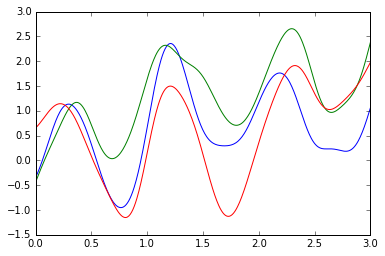

In [181]:
plt.plot(X, F1, X, F2, X, F3)
plt.show()

Observe some values and compute the posterior GP mean and covariance functions

In [182]:
Xtrain = [1, 1.5, 2.5]
Ytrain = [2, 3, 4]

posterior_GP_params = compute_posterior_GP(mu, k, Xtrain, Ytrain)

mbar = posterior_GP_params[0]
kbar = posterior_GP_params[1]

Draw a few samples from the posterior GP

In [183]:
F4 = sample_Gaussian_process(mbar, kbar, X)
F5 = sample_Gaussian_process(mbar, kbar, X)
F6 = sample_Gaussian_process(mbar, kbar, X)


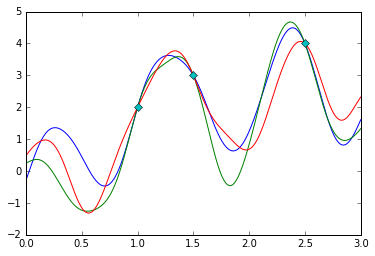

In [184]:
plt.plot(X, F4, X, F5, X, F6)
plt.hold(True)
plt.plot(Xtrain, Ytrain, 'cD')
plt.show()